In [12]:
from pathlib import Path
from course_intro_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [13]:
DATASET_PATH = Path().absolute().parent.parent / 'midv500' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [14]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_intro_ocr_t1.data.MidvPackage)

In [15]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)


(course_intro_ocr_t1.data.MidvPackage, 300, course_intro_ocr_t1.data.DataItem)

In [16]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(WindowsPath('c:/Users/bakyt/ml/midv500/midv500_compressed/01_alb_id/ground_truth/PS/PS01_11.json'),
 WindowsPath('c:/Users/bakyt/ml/midv500/midv500_compressed/01_alb_id/images/PS/PS01_11.tif'))

In [17]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[220, 299],
       [598, 315],
       [626, 571],
       [202, 541]])

[[0.48888889 0.37375   ]
 [1.32888889 0.39375   ]
 [1.39111111 0.71375   ]
 [0.44888889 0.67625   ]]


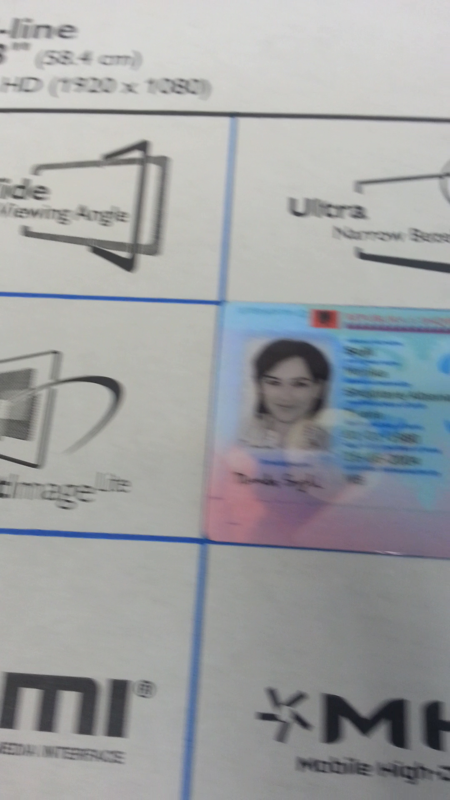

In [18]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

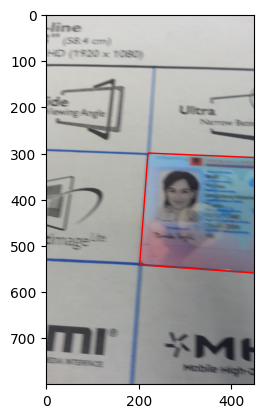

In [19]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [20]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, False)

True


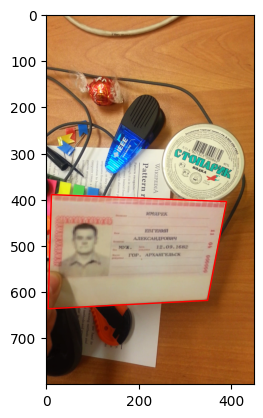

In [21]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [22]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|██████████| 50/50 [00:15<00:00,  3.29it/s]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [23]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████| 50/50 [00:02<00:00, 22.53it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


## Classic CV baseline

### Для работы baseline нужен установленныей OpenCV 

In [24]:
!pip install opencv-python

In [25]:
import cv2

In [26]:
class SimpleBaselineCrop:
    """
    Baseline на основе поиска и сопоставления ключевых точек на шаблоне(ref) и запросе(query)
    Алгоритм:
        0. Найти ключевые точки(КТ) на ref
        1. Найти ключевые точки(КТ) на query
        2. Сопоставить КТ query и ref друг-другу
        3. На основе сопоставления найти гомографию из ref в query
        4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
    """
    def __init__(self, ref_image):
        self.ref_image = ref_image
        
        # 0. Найти ключевые точки(КТ) на ref
        self.ref_kpts, self.ref_fts = self.compute_kps(
            self.ref_image
        )

    def compute_kps(self, img, response_quantile=0.25):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sift = cv2.SIFT_create()
        kp = sift.detect(gray, None)
        # фильтруем 25% неуверенных точек
        q_val = np.quantile(list(k.response for k in kp), response_quantile)
        kp = [k for k in kp if k.response > q_val]
        
        kp, features = sift.compute(gray, kp)
        return kp, features 
    
    def find_qr_homography(self, kp_q, ft_q, kp_r, ft_r, ratio=0.75):
        # 2. Сопоставить КТ query и ref друг-другу
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(ft_q, ft_r, k=2)
        good = []

        # Дополнителный опциональный шаг - фильтрация Lowe, Lowe ratio-test:
        # Пусть есть лучший матч1 (query-kp, ref-kp)
        # Если есть другой возможный матч2 (query-kp, ref-kp2), и их качество
        # (т.е. расстояние в пространстве features) маленькое,
        # то нельзя быть уверенном, что матч1 - надежный, и проще его выбросить
        for m,n in matches:
            if m.distance <  ratio * n.distance:
                good.append([m])
                
        ptsA = np.zeros((len(good), 2), dtype="float")
        ptsB = np.zeros((len(good), 2), dtype="float")

        for (i, mlist) in enumerate(good):
            m = mlist[0]
            ptsA[i] = kp_q[m.queryIdx].pt
            ptsB[i] = kp_r[m.trainIdx].pt
        # 3. На основе сопоставления найти гомографию из ref в query
        (H, mask) = cv2.findHomography(ptsB, ptsA, method=cv2.RANSAC)
        return H
              
    def compute_crop(self, ref_img, hmg):
        # 4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
        h, w, _ = ref_img.shape
        h = float(h)
        w = float(w)
        points = [
            [0, 0],
            [w, 0],
            [w, h],
            [0, h],
        ]
        points_crop = []
        for p in points:
            # применяем гомографию к точке, представленной в гомогенных координатах
            vec = hmg @ np.array([p[0], p[1], 1])
            points_crop.append([vec[0]/vec[-1], vec[1]/vec[-1]])
        return np.array(points_crop)
        
    def __call__(self, query_image):
        # 1. Найти ключевые точки(КТ) на query
        kpts, fts = self.compute_kps(query_image)
        
        homography = self.find_qr_homography(
            kpts, fts, self.ref_kpts, self.ref_fts
        )
        abs_crop = self.compute_crop(self.ref_image, homography)
        h, w, _ = query_image.shape
        rel_crop = abs_crop / np.array([[w, h]])
        return rel_crop

In [27]:
bcm = SimpleBaselineCrop(np.array(dp.template_item.image))

In [28]:
pred_quad = bcm(np.array(dp[0].image))

In [29]:
pred_quad, dp[0].quadrangle

(array([[0.05690939, 0.47378273],
        [0.73707284, 0.33397009],
        [0.92773878, 0.56708375],
        [0.22825794, 0.72939492]]),
 array([[0.05555556, 0.47375   ],
        [0.73555556, 0.335     ],
        [0.92666667, 0.5675    ],
        [0.22666667, 0.72875   ]]))

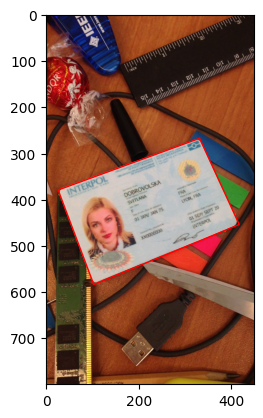

In [30]:
dp[0].show(pred_quad)

In [31]:
for dp in tqdm(data_packs):
    print(dp[i].image)
    bcm = SimpleBaselineCrop(np.array(dp.template_item.image))
    print(bcm(np.array(dp[i].image)))
    break

  0%|          | 0/50 [00:00<?, ?it/s]

<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=450x800 at 0x1B7FAA69190>


  0%|          | 0/50 [00:00<?, ?it/s]

[[0.04953318 0.37253117]
 [0.95211026 0.38797621]
 [0.9548144  0.70037749]
 [0.03675449 0.70442263]]


In [32]:
results_dict = dict()

for dp in tqdm(data_packs):
    bcm = SimpleBaselineCrop(np.array(dp.template_item.image))
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = bcm(np.array(dp[i].image))
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)


 22%|██▏       | 11/50 [01:19<04:44,  7.29s/it]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'



 42%|████▏     | 21/50 [02:32<03:27,  7.15s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


 84%|████████▍ | 42/50 [05:00<00:55,  6.97s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


 86%|████████▌ | 43/50 [05:08<00:49,  7.04s/it]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

Open

 88%|████████▊ | 44/50 [05:49<01:44, 17.49s/it]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


 90%|█████████ | 45/50 [06:34<02:07, 25.48s/it]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'



 92%|█████████▏| 46/50 [07:18<02:04, 31.07s/it]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'



 94%|█████████▍| 47/50 [08:07<01:49, 36.55s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


 96%|█████████▌| 48/50 [08:51<01:17, 38.68s/it]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

Open

 98%|█████████▊| 49/50 [09:34<00:40, 40.20s/it]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'



100%|██████████| 50/50 [10:15<00:00, 12.30s/it]


### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [33]:
from course_intro_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [34]:
results_dict

{'01_alb_id|ground_truth|CA|CA01_26.json': array([[0.05580827, 0.33688185],
        [0.84191802, 0.31796367],
        [0.8688937 , 0.59186544],
        [0.08210755, 0.61884111]]),
 '01_alb_id|ground_truth|CA|CA01_27.json': array([[0.0712448 , 0.34288934],
        [0.8384026 , 0.32466017],
        [0.86416466, 0.59243655],
        [0.09658811, 0.61890513]]),
 '01_alb_id|ground_truth|CA|CA01_28.json': array([[0.0854363 , 0.35099399],
        [0.83794402, 0.33366548],
        [0.86366679, 0.59593386],
        [0.10967372, 0.62192134]]),
 '01_alb_id|ground_truth|CA|CA01_29.json': array([[0.0889553 , 0.35195133],
        [0.8385166 , 0.33747577],
        [0.86634374, 0.59877785],
        [0.11281072, 0.62357211]]),
 '01_alb_id|ground_truth|CA|CA01_30.json': array([[0.07697976, 0.3374249 ],
        [0.85065177, 0.32395426],
        [0.87861492, 0.59283281],
        [0.10273532, 0.61617507]]),
 '01_alb_id|ground_truth|CS|CS01_26.json': array([[0.12000673, 0.41248845],
        [0.9307275 , 0.4

In [35]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [36]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [37]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.9619
